In [55]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import cv2 
import os
import math
import json

In [56]:
def normalize(tensor: torch.Tensor) -> torch.Tensor:
    return (tensor - tensor.min()) / (tensor.max() - tensor.min())
def process_tensor(tensor : torch.Tensor) -> np.array:
    if len(tensor.shape) == 3 and tensor.shape[0] == 3:
        tensor = tensor.permute(1, 2, 0).detach().cpu()
        tensor = tensor.numpy()
        # tensor[:, :, [0, 2]] = tensor[:, :, [2, 0]]
    elif len(tensor.shape) == 3 and tensor.shape[0] == 1:
        tensor = tensor[0].detach().cpu().squeeze()
        tensor = tensor.numpy()
    elif len(tensor.shape) == 2:
        tensor = tensor.detach().cpu().squeeze()
        tensor = tensor.numpy()
    return tensor
    

In [57]:
debug_tensor_path = "./debug_tensor"
debug_tensor_map : dict = {}
for filename in os.listdir(debug_tensor_path):
    if not filename.endswith(".pt"):
        continue
    debug_tensor_map[filename] = torch.load(os.path.join(debug_tensor_path, filename))

/tmp/ipykernel_4548/39882838.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  debug_tensor_map[filename] = torch.load(os.path.join(debug_tensor_path, filename))


In [58]:
processed_img : dict = {}
for key in debug_tensor_map:
    processed_img[key] = process_tensor(debug_tensor_map[key])
    print(f"{key}: {processed_img[key].shape}")

render.pt: (552, 982, 3)
rendered_normal.pt: (552, 982, 3)
depth_normal.pt: (552, 982, 3)
normal.pt: (552, 982, 3)
plane_depth.pt: (552, 982)
depth_metric.pt: (552, 982)


{'normal_loss': 0.002887535374611616, 'depth_loss': 0.03638105466961861}


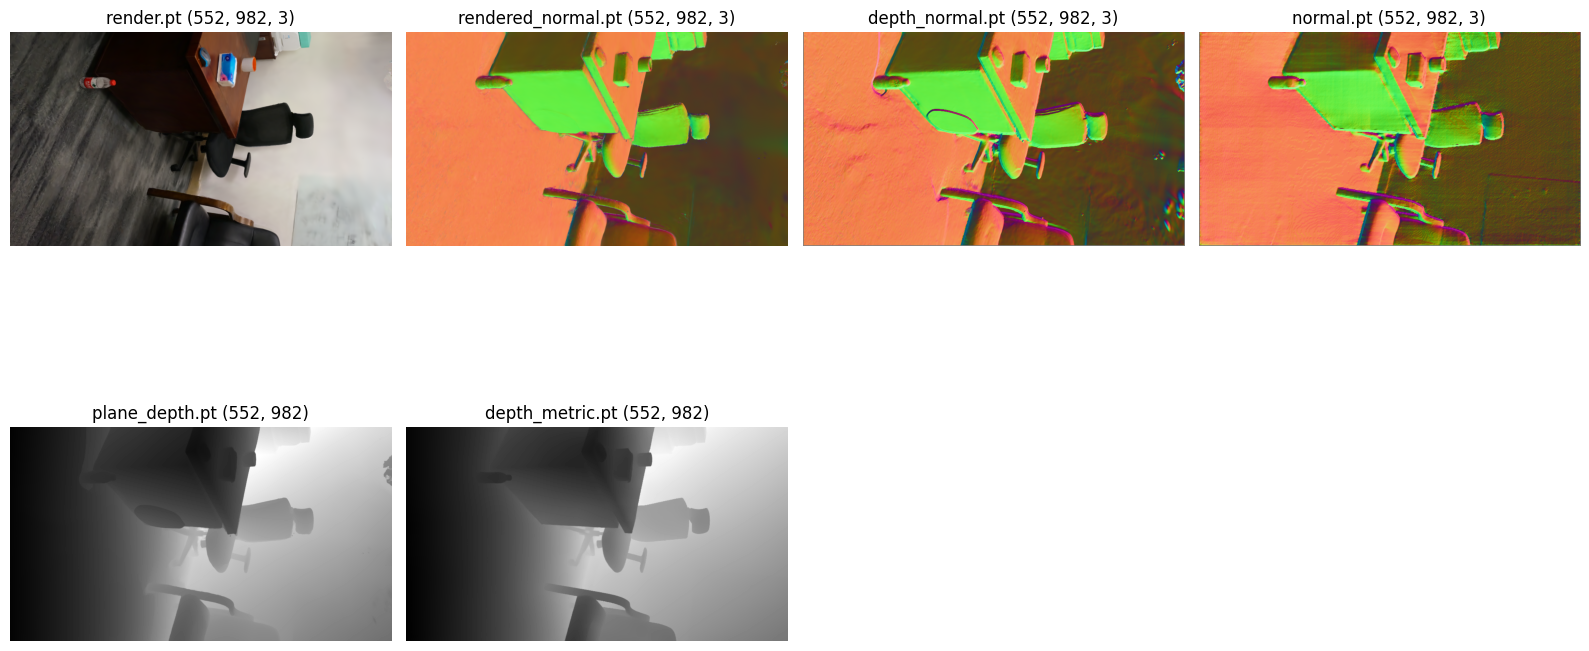

In [59]:
num_images = len(processed_img)
cols = math.ceil(math.sqrt(num_images)) + 1  # 每行的列数
rows = math.ceil(num_images / cols) + 1
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
for i, image_key in enumerate(processed_img):
    row = i // cols
    col = i % cols
    image = processed_img[image_key]
    if len(image.shape) == 3 and image.shape[2] == 3:
        axes[row, col].imshow(normalize(image))  # 彩色图片不需要cmap
    else:
        axes[row, col].imshow(image, cmap='gray')  # 黑白图片使用'gray' cmap

    axes[row, col].set_title(image_key + f" {image.shape}")
    axes[row, col].axis('off')  # 隐藏坐标轴

for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])  # 删除空白的子图
    

with open(os.path.join(debug_tensor_path, 'loss.json'), 'r', encoding='utf-8') as file:
    data = json.load(file)

# 输出 JSON 文件内容
print(data)


plt.tight_layout()
plt.show()

[ 0.95053846 -0.04411845 -0.30745775]


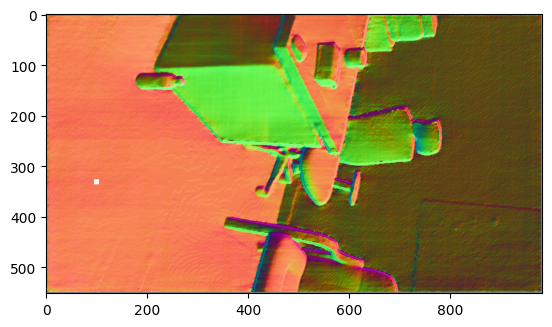

In [60]:
point = (-220, 100)
normal = processed_img["normal.pt"].copy()
print(normal[point[0], point[1]])
normal[point[0] - 5 : point[0] + 5, point[1] - 5 : point[1] + 5, :] = 1
plt.imshow(normalize(normal))